# Diskless Parcels

For input and output we completely rely on a Redis store running somewhere in the network.

In [1]:
## Run once for setup:
# %pip install redis
# %pip install git+https://github.com/willirath/parcels.git@f2e6c5cd0aeddfc8e74feea1519ef6a70614760d

## Set up diskless input data

We'll store a simple U, V field in a Redis store living in a different service. Then, we'll re-read the data to check if they look the same.

In [2]:
import zarr

In [3]:
uv_store = zarr.storage.RedisStore(prefix="uv_", host="redis_store", port=6379)

uv_store

In [4]:
import numpy as np
import xarray as xr

In [5]:
lon = xr.DataArray(np.linspace(-180, 180, 100), dims=("lon", ), name="lon")
lat = xr.DataArray(np.linspace(-90, 90, 100), dims=("lat", ), name="lat")

ds = xr.Dataset(dict(
    u=np.sin(np.deg2rad(2 * lat)).where(~lon.isnull()).rename("u"),
    v=-np.cos(np.deg2rad(4 * lat)).where(~lon.isnull()).rename("v")
))

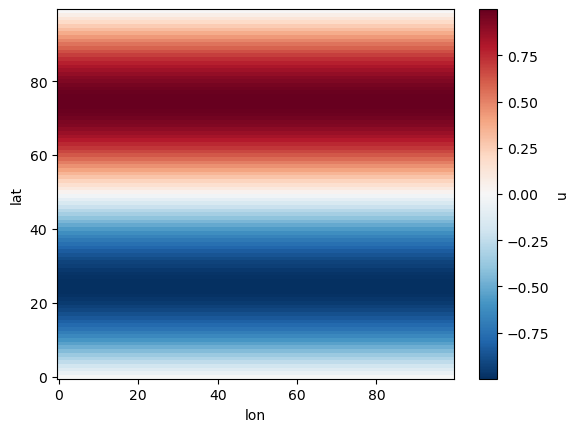

In [6]:
ds.u.plot()

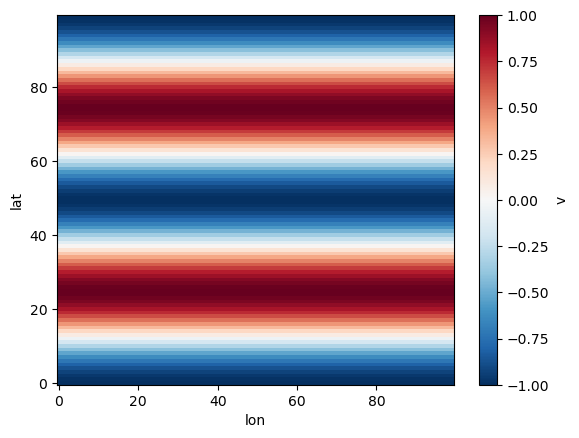

In [7]:
ds.v.plot()

In [8]:
ds.to_zarr(uv_store, mode="w")

In [9]:
ds_reread = xr.open_zarr(uv_store)

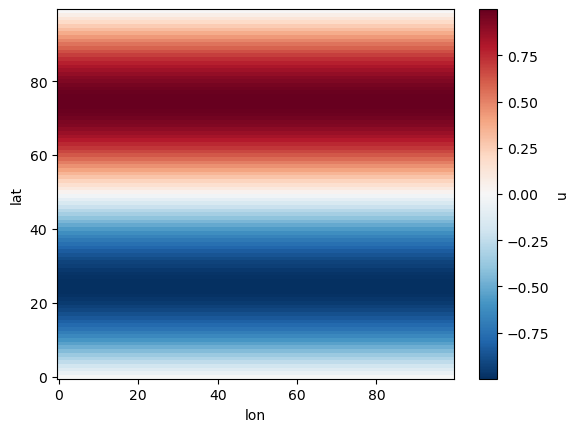

In [10]:
ds_reread.u.plot()

## The Parcels experiment

In [11]:
from parcels import FieldSet, ParticleSet, ScipyParticle, AdvectionRK4, ParticleFile
from parcels.particlefile.baseparticlefile import BaseParticleFile
from datetime import timedelta, datetime

## Fieldset from the Redis store

(So the input data is read from a web service.)

In [12]:
fieldset = FieldSet.from_xarray_dataset(
    xr.open_zarr(uv_store),
    variables={"U": "u", "V": "v"},
    dimensions={"lat": "lat", "lon": "lon"}
)

## A very simple particle set starting in Kiel

In [13]:
pset = ParticleSet.from_list(
    fieldset=fieldset,
    pclass=ScipyParticle,
    lon=[10, ],
    lat=[53, ],
    time=[0, ],
)

## Streaming _to_ a Redis store

In [14]:
outstore = zarr.storage.RedisStore(prefix="output_", host="redis_store", port=6379)

Note the `ParticleFile` was hacked to not assume what's given as name is a directory name but can be a Zarr store object.

In [15]:
outputfile = pset.ParticleFile(name=outstore, outputdt=3600)

Execute. (Would be interesting to compare timing with local output.)

In [16]:
pset.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=1),
    output_file=outputfile,
)

INFO: Output files are stored in <zarr.storage.RedisStore object at 0x7f860bd44f70>.
100%|██████████| 864000.0/864000.0 [00:19<00:00, 43460.73it/s]  


## Check outputs

Read from the Redis store. We create a second store object just to make sure there's no hidden caching going on. :)

In [17]:
outstore_opened_again = zarr.storage.RedisStore(prefix="output_", host="redis_store", port=6379)

In [18]:
ds_out = xr.open_zarr(outstore_opened_again)

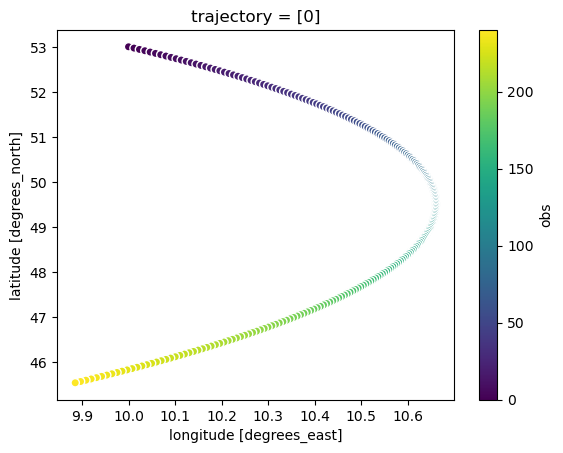

In [19]:
ds_out.plot.scatter(x="lon", y="lat")